## Imports

In [30]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
from tqdm.notebook import tqdm
import scipy
import pickle
from kernels import K_classical, K_simple_RX, K_phi_RX, K_layered, K_L_tower, K_L_cheb
from util import quantum_dataset, plot_results, plot_mmr_results
from itertools import product
from optim import mmr, multivalued_mmr_DE, SVR_fit, mmr_DE


## Kernel

### Visualize Kernel

Loading XYZ kernel data
Loading RBF kernel data
[Errno 2] No such file or directory: 'data/[RBF]_kernel_plot_data.npy'
Loading L-prod kernel data
Loading L-tower kernel data
Loading L-cheb kernel data
Loading phi_RX kernel data
[Errno 2] No such file or directory: 'data/[phi_RX]_kernel_plot_data.npy'
Loading L-tower_HA kernel data


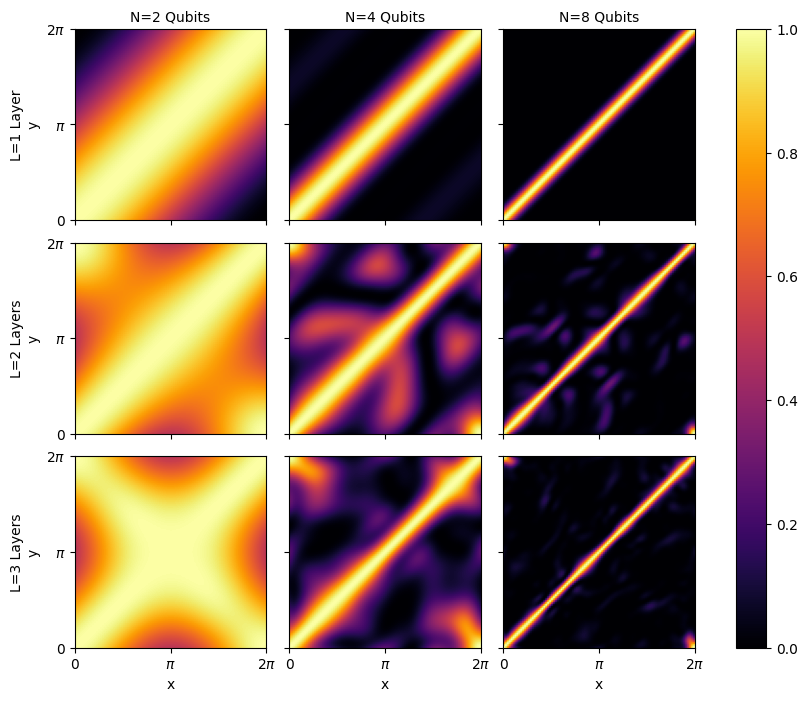

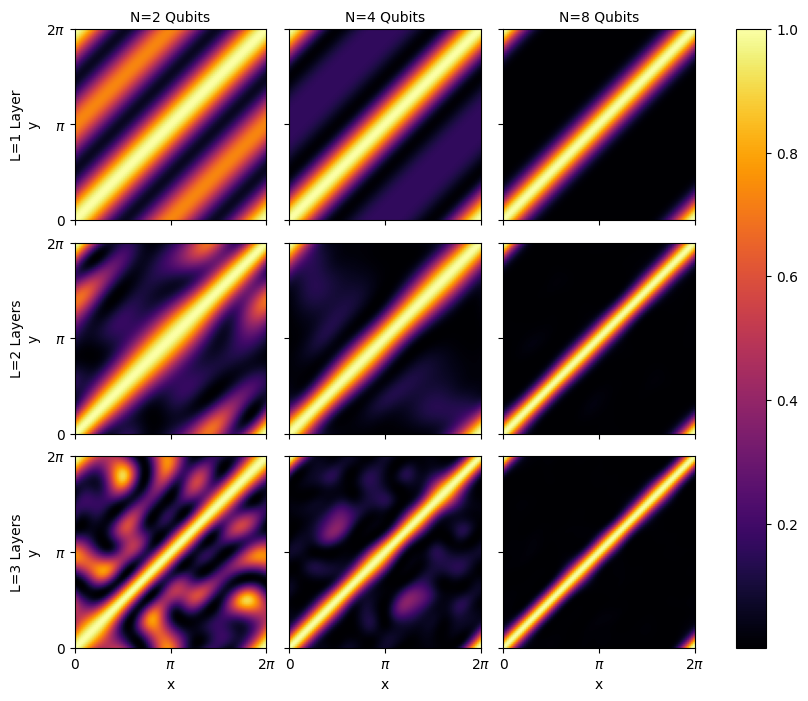

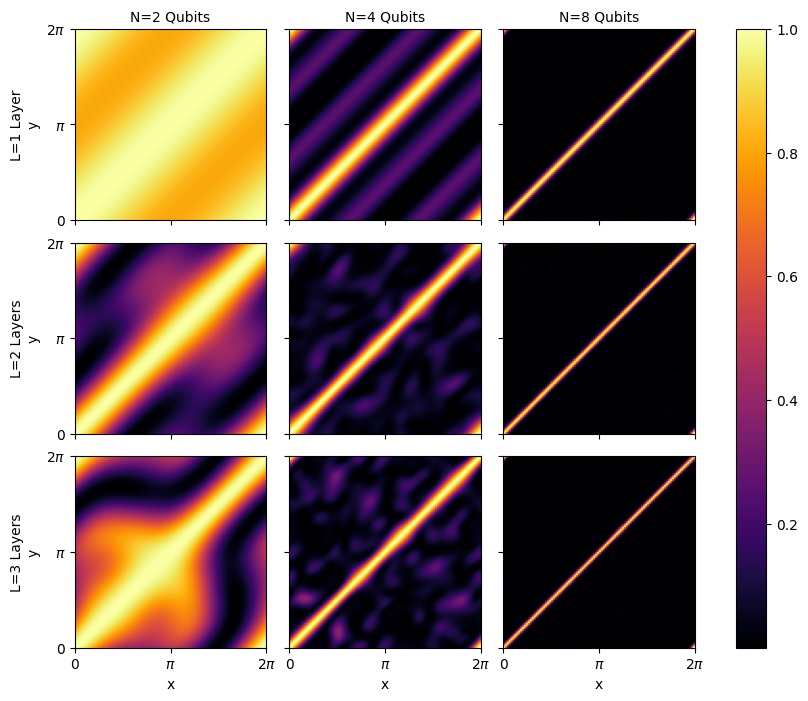

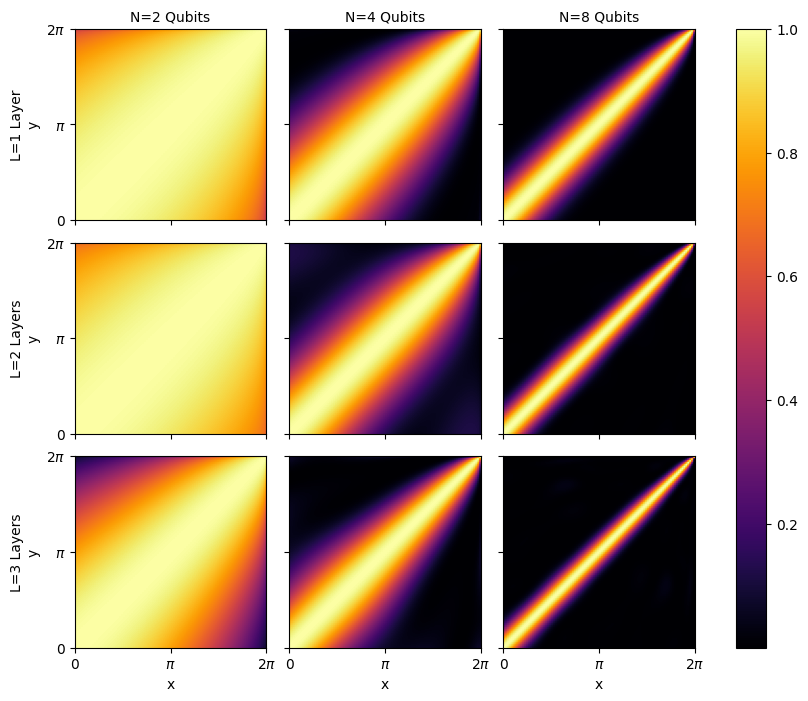

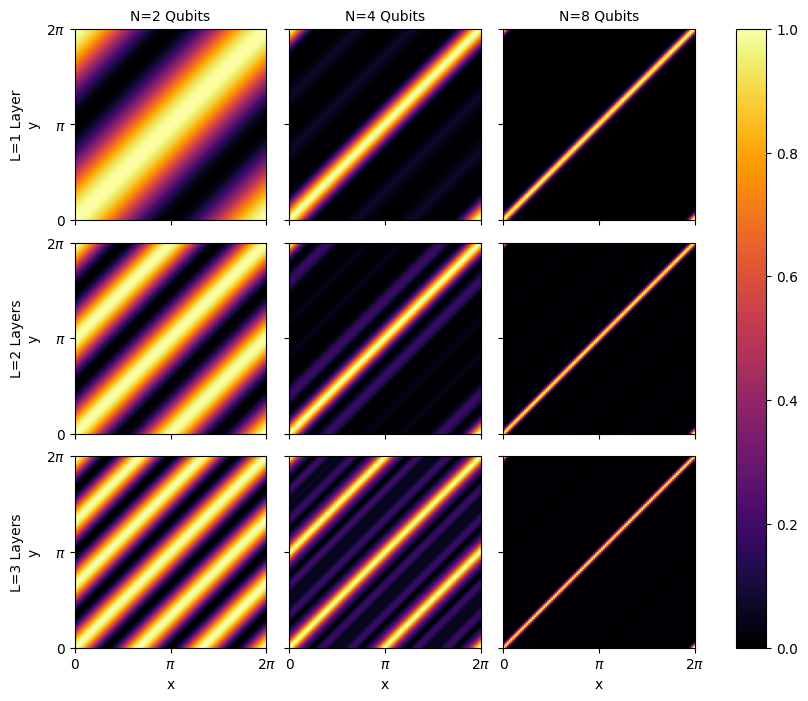

In [8]:
from kernel_plot_data import plot_kernel_data, kernels

kernel_plot_datas = {}
for kernel_label in kernels:
    # check if file exists
    try:
        print(f"Loading {kernel_label} kernel data")
        kernel_label_data = np.load(f"data/[{kernel_label}]_kernel_plot_data.npy", allow_pickle=True)
        plot_kernel_data(kernel_label_data, kernel_label, save=True)
    except Exception as e:
        print(e)
        continue
    

In [9]:
def loss_plot(lossesArray, labels=None):
    for i, losses in enumerate(lossesArray):
        label = labels[i] if labels is not None else f"loss {i}"
        plt.plot(losses, label=label)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.legend()
    plt.show()

## Results

### $f(x) = x^2$

In [29]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

In [30]:
k = K_classical(0.14)
f,_ = mmr(X=x, Y=x, F=y, K=k)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 15
         Hessian evaluations: 0


In [31]:
k = K_layered(8, n_layers=5)
f_q,_ = mmr(X=x, Y=x, F=y, K=k)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 161
         Hessian evaluations: 0


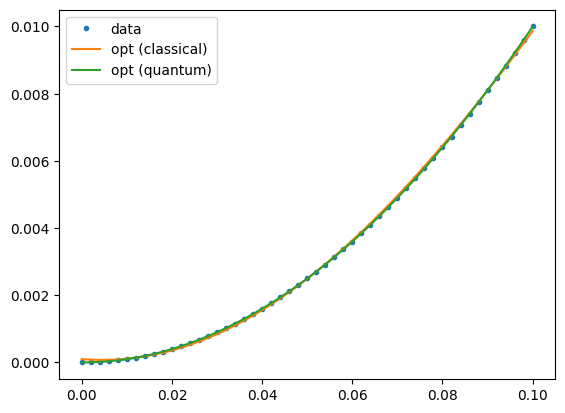

In [32]:
plt.plot(x, y, ".", label="data")
plt.plot(x, [f(x) for x in x], label="opt (classical)")
plt.plot(x, [f_q(x) for x in x], label="opt (quantum)")
plt.legend()
plt.show()

### Honeycomb magnetization dataset

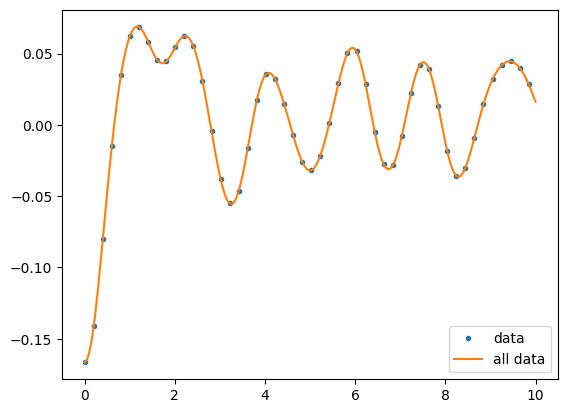

In [24]:
data = quantum_dataset(n_samples=200)

x = data[:, 0]
y = data[:, 1]

x_train = x[::4]
y_train = y[::4]

data = np.array([x_train, y_train])
plt.plot(x_train, y_train, ".", label="data")
plt.plot(x, y, label="all data")
plt.legend()

In [25]:
k = K_classical(0.20)
f, losses_classical = mmr(X=x_train, Y=x_train, F=y_train, K=k)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 849
         Hessian evaluations: 0


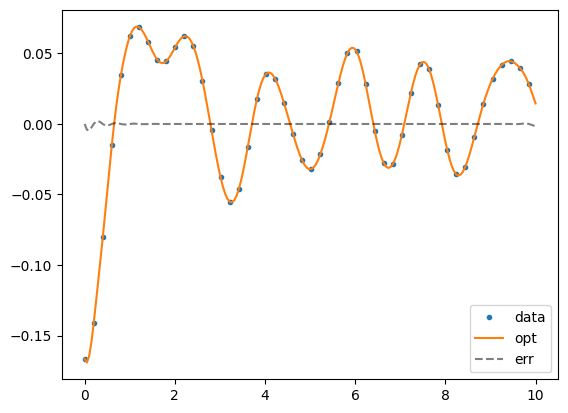

In [26]:
mmr_classical_predict = np.array([f(x) for x in x])

plt.plot(x_train, y_train, ".", label="data")
plt.plot(x, mmr_classical_predict, label="opt")
plt.plot(x, mmr_classical_predict - y, "--", label="err", alpha=0.5, color="black")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

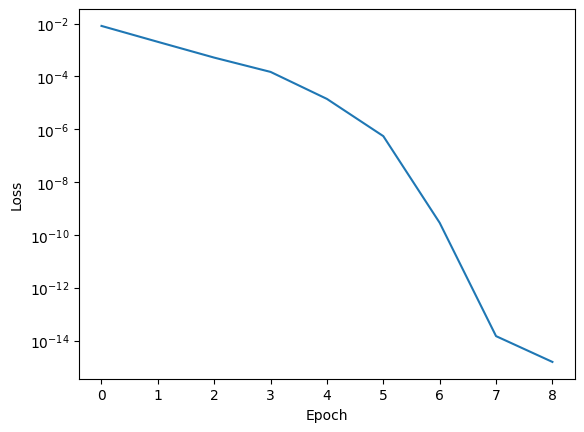

In [27]:
plt.plot(losses_classical)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [28]:
k = K_layered(8, n_layers=3)
f_q, losses_quantum = mmr(X=x_train, Y=x_train, F=y_train, K=k)

         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 3842
         Hessian evaluations: 0


/Users/leonardeyer/Documents/Notes/Uni/Applied Quantum Algorithms/Project/QKM/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2104: OptimizeWarning: Warning: CG iterations didn't converge. The Hessian is not positive definite.
  return terminate(3, msg)


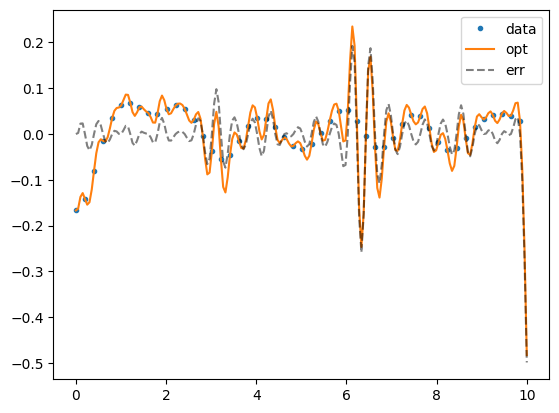

In [29]:
mmr_quantum_predict = np.array([f_q(x) for x in x])

plt.plot(x_train, y_train, ".", label="data")
plt.plot(x, mmr_quantum_predict, label="opt")
plt.plot(x, mmr_quantum_predict - y, "--", label="err", alpha=0.5, color="black")
plt.legend()
plt.show()

In [19]:
params = {
    "training_data": (x_train, y_train),
    "optimized": {
        "MMR RBF": (x, mmr_classical_predict),
        "MMR QK": (x, mmr_quantum_predict),
    },
    "errors": {
        "MMR RBF": (x, mmr_classical_predict - y),
        "MMR QK": (x, mmr_quantum_predict - y)
    },
    "losses": {
        "MMR RBF": losses_classical,
        "MMR QK": losses_quantum
    }
}

# save results
pickle.dump(params, open("data/honeycomb_magnetization_results.pkl", "wb"))

ValueError: x and y must have same first dimension, but have shapes (21, 1) and (200,)

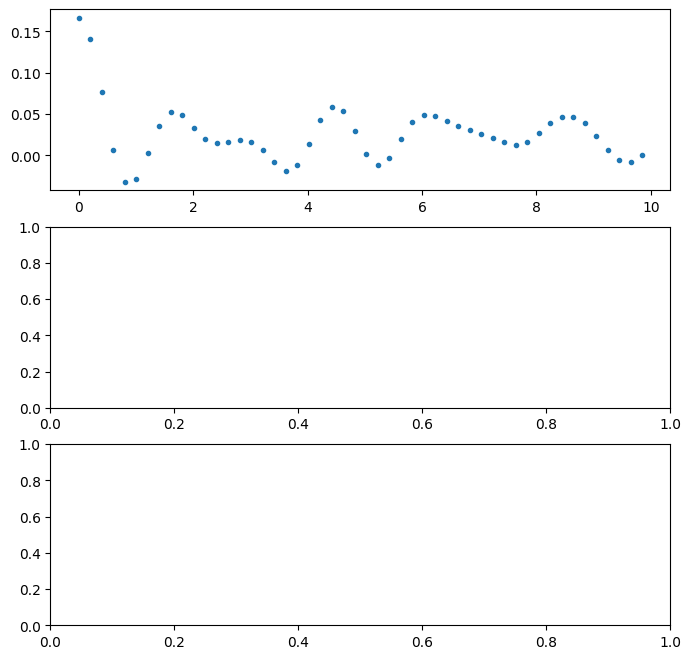

In [20]:
params = pickle.load(open("data/honeycomb_magnetization_results.pkl", "rb"))

plot_mmr_results(**params)

In [14]:
kernel_classical = K_classical(0.2)
kernel_quantum = K_L_tower(8, n_layers=2)

x_input = x.reshape(-1, 1)
y_input = y

svr_classic = SVR_fit(X=x_input, Y=y_input, K=kernel_classical, params= {'C': 1, 'epsilon': 0.001, 'gamma': 0.1})
svr_classic_predictions = svr_classic.predict(x_input)

#x_input = (x / np.max(x) * np.pi * 2 * 0.75).reshape(-1, 1)
svr_quantum = SVR_fit(X=x_input, Y=y_input, K=kernel_quantum)#, params={'C': 1, 'epsilon': 0.1, 'gamma': 10**9} )

svr_quantum_predictions = svr_quantum.predict(x_input)

[LibSVM]*.*
optimization finished, #iter = 163
obj = -0.131415, rho = 0.144876
nSV = 47, nBSV = 0
[LibSVM]*
optimization finished, #iter = 22
obj = -0.041820, rho = 0.161657
nSV = 19, nBSV = 0


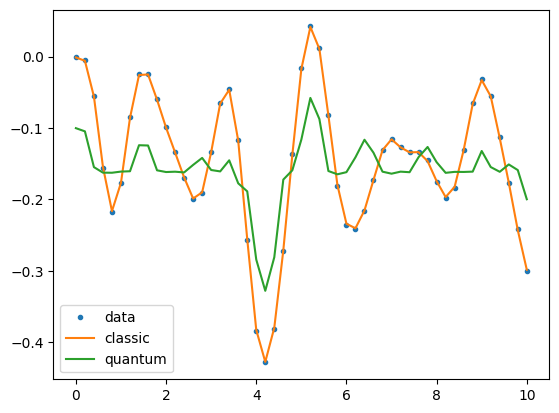

In [15]:
plt.plot(x, y, ".", label="data")
plt.plot(x, svr_classic_predictions, label="classic")
plt.plot(x, svr_quantum_predictions, label="quantum")
plt.legend()
plt.show()

### $\frac{df}{dx} = -\lambda \kappa f - \lambda \exp(\lambda \kappa x)\sin(\lambda x)$

with Solution: $f_{sol}(x) = -\lambda \exp(-\lambda \kappa x)\cos(\lambda x)$

In [15]:
def make_DE(llambda, kk):
    def df_dx(x, f, l, k):
        return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)
    
    def DE(x, f, dfdx):
        return dfdx - df_dx(x, f, llambda, kk)
    
    def f_sol(x):
        return np.exp(-llambda * kk * x) * np.cos(llambda * x)
    
    return DE, f_sol    

llambda = 20
kk = 0.1

DE, sol = make_DE(llambda, kk)

In [16]:
x = np.linspace(0, 1, 21).reshape(21, 1)
y = x

In [32]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import NoiseModel

backend = GenericBackendV2(num_qubits=8)
noise_model = NoiseModel.from_backend(backend)

trial_kernels = {
    "2L Tower": K_L_tower(8, n_layers=2),
    "2L Tower (noisy)": K_L_tower(8, n_layers=2, noise_model=noise_model, qml_backend="qiskit.aer", shots=1024 * 100),
    "XYZ":  K_layered(8, n_layers=3),
    "XYZ (noisy)":  K_layered(8, n_layers=3, noise_model=noise_model, qml_backend="qiskit.aer", shots=1024 * 100),
}

In [ ]:
results = {}

for kernel_label, kernel in trial_kernels.items():
    print(f"Optimizing {kernel_label} kernel")
    f, losses = mmr_DE(DE=DE, data=[x, y], x0=0, f0=1, k=kernel)
    results[kernel_label] = (f, losses)

Optimizing 2L Tower kernel


In [ ]:
data = {}

for kernel_label, (f, losses) in results.items():
    xs = np.linspace(0, 1, 100)
    data[kernel_label] = (xs, [f(x) for x in xs])

In [ ]:
k = K_layered(8, n_layers=5)
f_m = multivalued_mmr_DE(DE, [x, y], np.array([0.]), np.array([1.]), k)

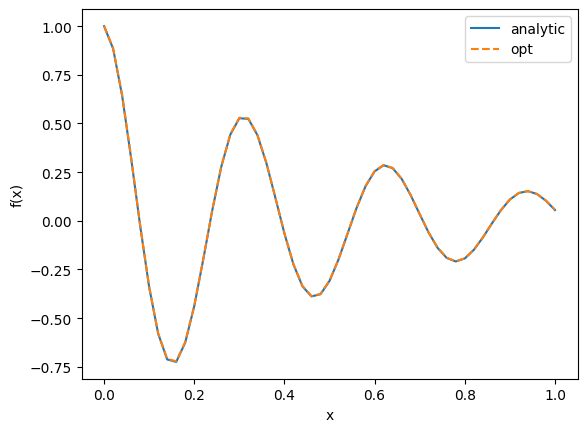

In [5]:
x = np.linspace(0, 1, 51)
y = x
xs = np.reshape(x, (len(x), -1))
plt.plot(xs, [sol(x) for x in xs], label="analytic")
plt.plot(xs, [f_m(x) for x in xs], label="opt", linestyle="--")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend()
plt.show()

- reproduce regression figure (Fig 1)

- mmmr de linear/nonlinear with noise with varying k

### Duffing equation

In [20]:
a = 0.5
b = 0.15
c = 3
e = 3 * np.pi

def make_duffing_DE():
    def d2f_d2x(x, f):
        return c*np.cos(e*x) - a * f - b * f**3
    
    def DE(x, f, dfdx):
        return np.array([f[1]-dfdx[0], dfdx[1]-d2f_d2x(x[0], f[0])])
    
    return DE

In [21]:
DE = make_duffing_DE()
x = np.linspace(0, 1, 21).reshape(21, 1)
y = np.array([[x], [x]]).reshape((len(x), 2))

In [22]:
k = K_layered(5, n_layers=2)
f_m = multivalued_mmr_DE(DE, [x, y], np.array([0.]), np.array([1., 1.]), k, IC_weight=10)


def d2f_d2x(x, f):
    return c * np.cos(e * x) - a * f - b * f ** 3

def dfdx(f, x):
    return np.array([f[1], d2f_d2x(x, f[0])])

f_sol = scipy.integrate.odeint(dfdx, np.array([1., 1.]), np.linspace(0, 1, 51))
f_qk = [f_m(x)[0] for x in xs]

Optimization terminated successfully.
         Current function value: 0.008294
         Iterations: 20
         Function evaluations: 46
         Gradient evaluations: 1942
         Hessian evaluations: 0


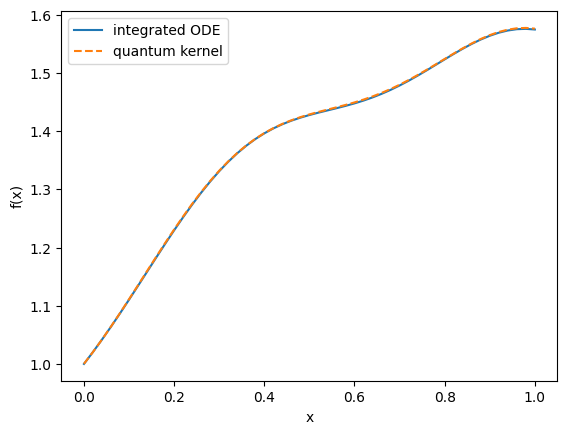

In [23]:
x = np.linspace(0, 1, 51)
y = x
xs = np.reshape(x, (len(x), -1))
plt.plot(xs, f_sol[:, 0], label="integrated ODE")
plt.plot(xs, f_qk, label="quantum kernel", linestyle="--")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend()
plt.show()